In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ========================================================
# = Parameters for plotting
# ========================================================
FONT_SIZE = 14
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE,
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')

# 1 Read Data

In [3]:
## read data
df_trraw = pd.read_csv('dataset/preprocessed/train_daily_recurring_clipping_normal.csv')
df_ttraw = pd.read_csv('dataset/preprocessed/test_daily_recurring_clipping_normal.csv')
df_trnorm = pd.read_csv('dataset/preprocessed/stdnorm_train_daily_recurring_clipping_normal.csv')
df_ttnorm = pd.read_csv('dataset/preprocessed/stdnorm_test_daily_recurring_clipping_normal.csv')

In [4]:
df_trraw.head()

,date,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,...,23:30:00,23:45:00,dcPvsize,faultID,faultname,MID,ClearSky,Mean_value,Std_value,Max_value
0,2022-11-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1050.0,L1F004,Recurring Underperformance,MNTR|SNGL-U1OH-RC8R-W8EH,True,329.748285,316.753534,815.666667
1,2022-11-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1050.0,L1F004,Recurring Underperformance,MNTR|SNGL-U1OH-RC8R-W8EH,True,329.748285,316.753534,815.666667
2,2022-11-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1050.0,L1F004,Recurring Underperformance,MNTR|SNGL-U1OH-RC8R-W8EH,True,329.748285,316.753534,815.666667
3,2022-11-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1050.0,L1F004,Recurring Underperformance,MNTR|SNGL-U1OH-RC8R-W8EH,True,329.748285,316.753534,815.666667
4,2022-11-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1050.0,L1F004,Recurring Underperformance,MNTR|SNGL-U1OH-RC8R-W8EH,True,329.748285,316.753534,815.666667


# 2 Model Traning

## 2.1 Label Binarize

In [5]:
# concern_fault = 'Recurring Underperformance'
concern_fault = 'Generation Clipping'
df_trraw['Label'] = df_trraw['faultname']== concern_fault 
df_trraw['Label'] = df_trraw['Label'].astype(int)
df_ttraw['Label'] = df_ttraw['faultname']== concern_fault 
df_ttraw['Label'] = df_ttraw['Label'].astype(int)

df_trnorm['Label'] = df_trnorm['faultname']== concern_fault 
df_trnorm['Label'] = df_trnorm['Label'].astype(int)
df_ttnorm['Label'] = df_ttnorm['faultname']== concern_fault 
df_ttnorm['Label'] = df_ttnorm['Label'].astype(int)

df_trraw[df_trraw['Label']==1]
labelnum_mapping = {1: concern_fault , 0: 'Others'}
label_mapping = {concern_fault:1, 'Others': 0}

In [6]:
df_trraw_clearsky = df_trraw[df_trraw['ClearSky']!=False].copy()
df_trraw_clearsky.index = np.arange(len(df_trraw_clearsky))
df_trnorm_clearsky = df_trnorm[df_trnorm['ClearSky']!=False].copy()
df_trnorm_clearsky.index = np.arange(len(df_trnorm_clearsky))
print('{}:'.format(concern_fault), len(df_trraw_clearsky[df_trraw_clearsky['Label']==1]))
print('Non-{}:'.format(concern_fault), len(df_trraw_clearsky[df_trraw_clearsky['Label']==0]))

Generation Clipping: 147
Non-Generation Clipping: 150


In [7]:
df_ttraw_clearsky = df_ttraw[df_ttraw['ClearSky']!=False].copy()
df_ttraw_clearsky.index = np.arange(len(df_ttraw_clearsky))
df_ttnorm_clearsky = df_ttnorm[df_ttnorm['ClearSky']!=False].copy()
df_ttnorm_clearsky.index = np.arange(len(df_ttnorm_clearsky))
print('{}:'.format(concern_fault), len(df_ttraw_clearsky[df_ttraw_clearsky['Label']==1]))
print('Non-{}:'.format(concern_fault), len(df_ttraw_clearsky[df_ttraw_clearsky['Label']==0]))

Generation Clipping: 33
Non-Generation Clipping: 36


## 2.2 Plot Functions

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, confusion_matrix

In [9]:
def plt_confusion_matrix(y_test, y_pred):
    # Compute the confusion matrix
    labels = np.unique(y_test.values.tolist() + y_pred.tolist())
    print(labels)
    cm = confusion_matrix(y_test.values, y_pred, labels=labels)

    # Plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    print(list(label_mapping.values()))
    print(list(label_mapping.keys()))
    plt.xticks(list(label_mapping.values()), list(label_mapping.keys()))
    plt.yticks(list(label_mapping.values()), list(label_mapping.keys()))
    plt.xticks(rotation=90)  
    # plt.yticks(rotation=90)  
    plt.show()

In [10]:
def cal_metrics(y_test, y_pred):
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    print('f1 score:', f1)

## 2.3 Prepare Data for NN Training

In [11]:
import torch
import torch.nn as nn

In [12]:
# Define a function to prepare the data
def prepare_sequence(df):
    sequences = []
    targets = []
    for i in range(len(df)):
        data = df.iloc[i, 1:97]
        sequences.append(data)
        label = df.iloc[i]['Label']
        targets.append(label)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


In [13]:
## train dataset
x_tr, y_tr = prepare_sequence(df_trnorm)
# x_tr = x_tr.view(x_tr.size()[1], -1, x_tr.size()[0])
x_tt, y_tt = prepare_sequence(df_ttnorm)
# x_tt = x_tt.view(x_tt.size()[1], -1, x_tt.size()[0])
print(np.shape(x_tt))

torch.Size([69, 96])


## 2.3 LSTM

In [14]:
# Define the LSTM model for binary classification
class BinaryLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(BinaryLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()  # Sigmoid activation for binary classification
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use the output from the last time step
        return out

In [15]:
batch_size = 128
# Create data loaders for mini-batch training
train_dataset = torch.utils.data.TensorDataset(x_tr, y_tr)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
input_size = 1
hidden_size = 64
output_size = 1
num_layers = 1
learning_rate = 0.001
# Create the binary classification model
model = BinaryLSTMModel(input_size, hidden_size, output_size, num_layers)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [16]:

# Training loop
num_epochs = 300
# input [L, N, H], L: sequence length, N: batch size, H: input size

# Training loop with mini-batches
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.view(-1, inputs.size()[1], input_size)
        # print(inputs.size())
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))  # Reshape y to match the output shape
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the binary classification model
model.eval()
with torch.no_grad():
    test_input = x_tt.view(-1, x_tt.size()[1], input_size)
    predicted = model(test_input).numpy()
    predicted_binary = (predicted > 0.5).astype(np.float32)


Epoch [10/300], Loss: 0.6883
Epoch [20/300], Loss: 0.6777
Epoch [30/300], Loss: 0.5434
Epoch [40/300], Loss: 0.4311
Epoch [50/300], Loss: 0.4953
Epoch [60/300], Loss: 0.4778
Epoch [70/300], Loss: 0.4631
Epoch [80/300], Loss: 0.4309
Epoch [90/300], Loss: 0.4902
Epoch [100/300], Loss: 0.4207
Epoch [110/300], Loss: 0.5412
Epoch [120/300], Loss: 0.4056
Epoch [130/300], Loss: 0.3911
Epoch [140/300], Loss: 0.3776
Epoch [150/300], Loss: 0.4356
Epoch [160/300], Loss: 0.3663
Epoch [170/300], Loss: 0.4081
Epoch [180/300], Loss: 0.2336
Epoch [190/300], Loss: 0.5244
Epoch [200/300], Loss: 0.3696
Epoch [210/300], Loss: 0.5230
Epoch [220/300], Loss: 0.4802
Epoch [230/300], Loss: 0.4775
Epoch [240/300], Loss: 0.3673
Epoch [250/300], Loss: 0.3620
Epoch [260/300], Loss: 0.3844
Epoch [270/300], Loss: 0.2482
Epoch [280/300], Loss: 0.3329
Epoch [290/300], Loss: 0.3966
Epoch [300/300], Loss: 0.3045


In [17]:
lstm_ypred =  [i[0] for i in predicted_binary]
y_test = y_tt.tolist()
cal_metrics(y_test=y_test, y_pred=lstm_ypred)

Accuracy: 0.7391304347826086
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      1.00      0.80        36
         1.0       1.00      0.45      0.62        33

    accuracy                           0.74        69
   macro avg       0.83      0.73      0.71        69
weighted avg       0.83      0.74      0.72        69

f1 score: 0.7125


# 3 Check the results

In [24]:
x_tt

tensor([[-0.8506, -0.8506, -0.8506,  ..., -0.8506, -0.8506, -0.8506],
        [-0.8506, -0.8506, -0.8506,  ..., -0.8506, -0.8506, -0.8506],
        [-0.8506, -0.8506, -0.8506,  ..., -0.8506, -0.8506, -0.8506],
        ...,
        [-1.7108, -1.7108, -1.7108,  ..., -1.7108, -1.7108, -1.7108],
        [-1.7108, -1.7108, -1.7108,  ..., -1.7108, -1.7108, -1.7108],
        [-1.7108, -1.7108, -1.7108,  ..., -1.7108, -1.7108, -1.7108]])

In [26]:
# Select the misclassified samples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, lstm_ypred)) if true != pred]
print(misclassified_indices)
missclassified_result = pd.DataFrame(index=range(len(misclassified_indices)), columns=['True_Label', 'Pred_Label'])
for i in range(len(misclassified_indices)):
    missclassified_result.iloc[i, 0] = int(y_test[misclassified_indices[i]])
    missclassified_result.iloc[i, 1] = int(lstm_ypred[misclassified_indices[i]])
misclassified_samples = df_ttraw_clearsky.iloc[misclassified_indices, :].copy()
misclassified_samples['estimated_label'] = missclassified_result.iloc[:, 1].values
print('total test samples: {}, misclassified sample number: {}'.format(len(y_test), len(misclassified_samples)))
misclassified_samples.head()


[26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 41, 42, 43, 51, 54]
total test samples: 69, misclassified sample number: 18


,date,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,...,dcPvsize,faultID,faultname,MID,ClearSky,Mean_value,Std_value,Max_value,Label,estimated_label
26,2022-02-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39600.0,L1F002,Generation Clipping,MNTR|301082,True,18433.419753,10391.646969,30088.0,1,0
27,2022-02-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39600.0,L1F002,Generation Clipping,MNTR|301082,True,18433.419753,10391.646969,30088.0,1,0
28,2022-02-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39600.0,L1F002,Generation Clipping,MNTR|301082,True,18433.419753,10391.646969,30088.0,1,0
29,2022-02-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39600.0,L1F002,Generation Clipping,MNTR|301082,True,18433.419753,10391.646969,30088.0,1,0
30,2022-02-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39600.0,L1F002,Generation Clipping,MNTR|301082,True,18433.419753,10391.646969,30088.0,1,0


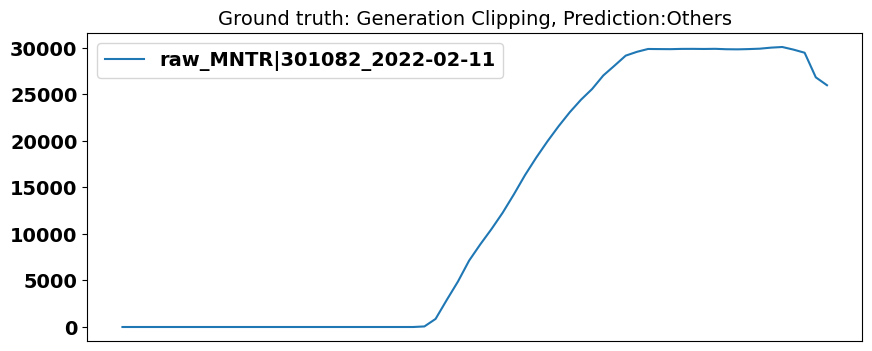

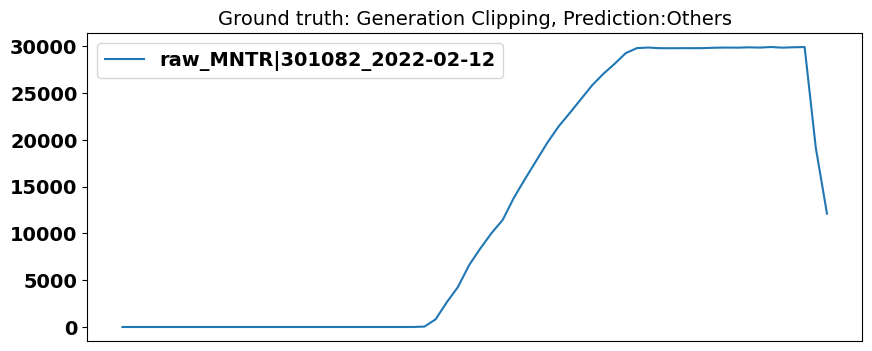

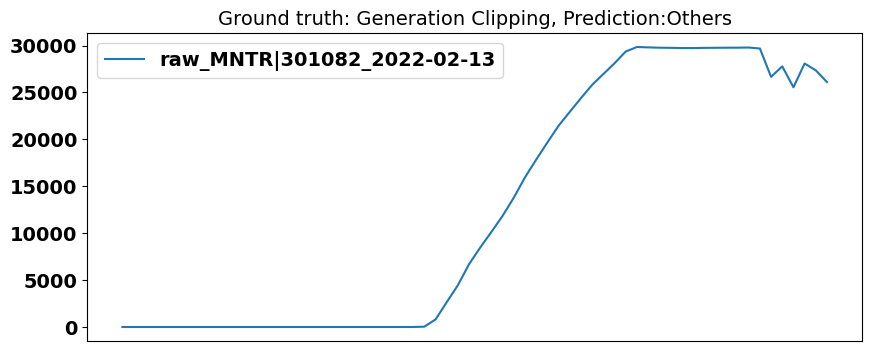

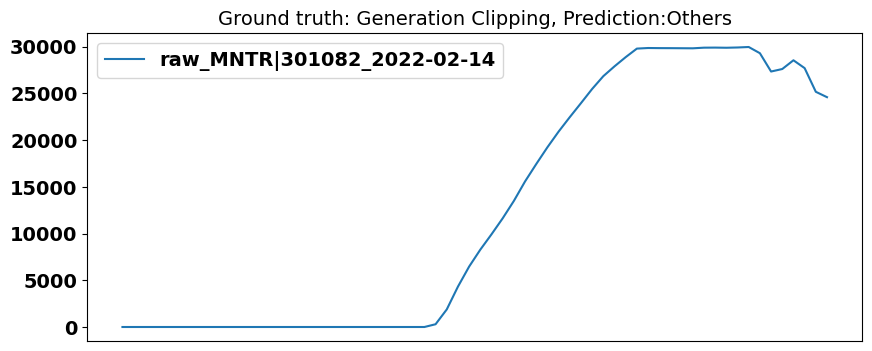

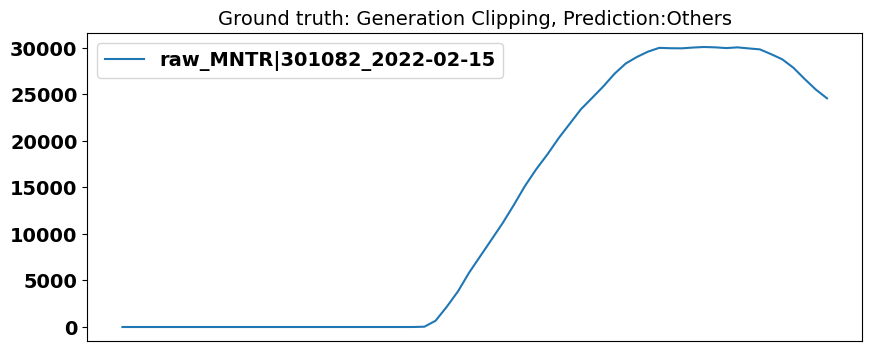

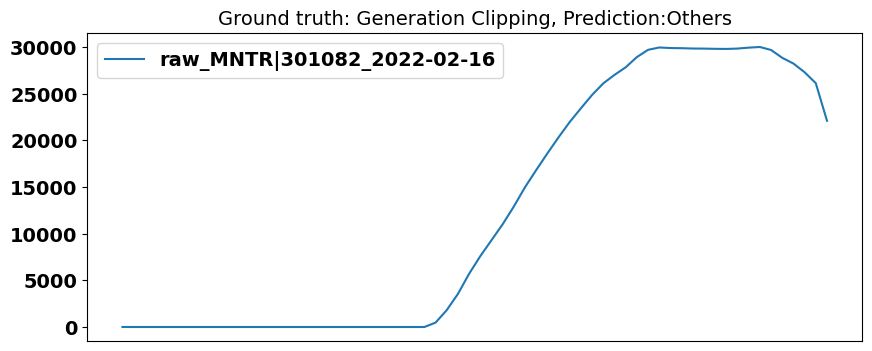

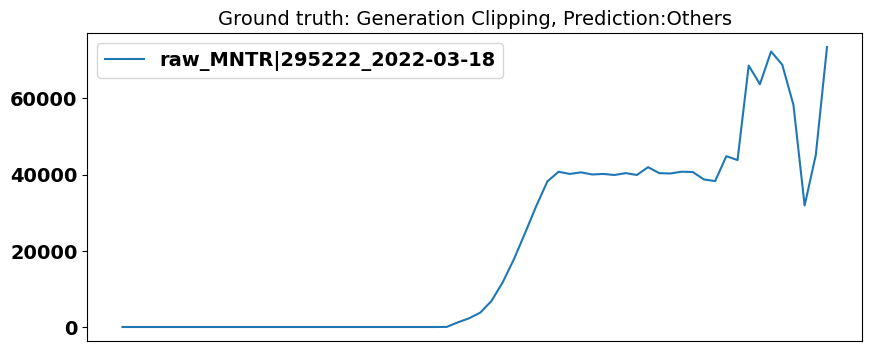

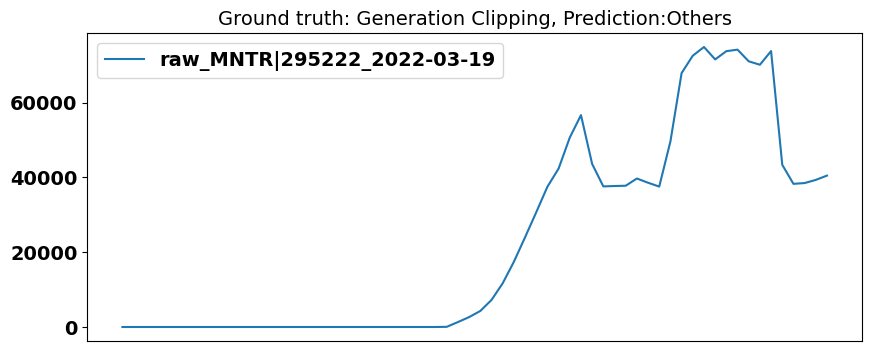

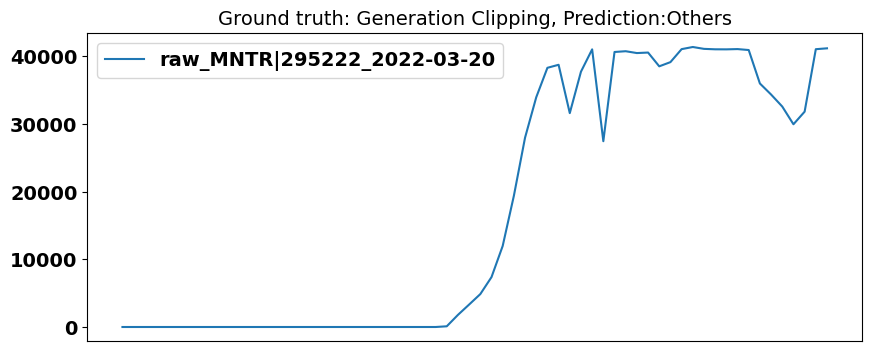

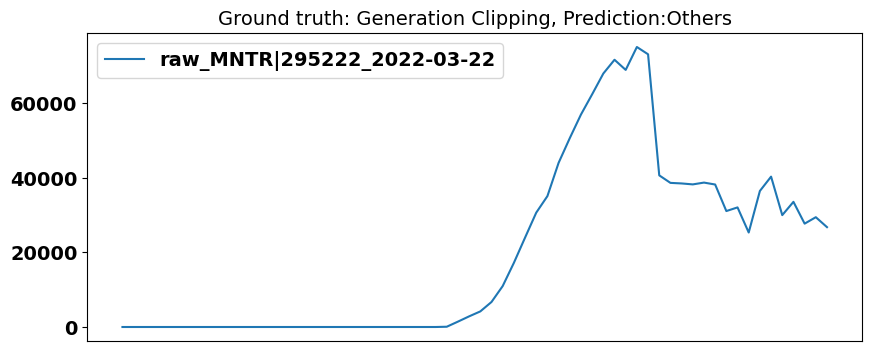

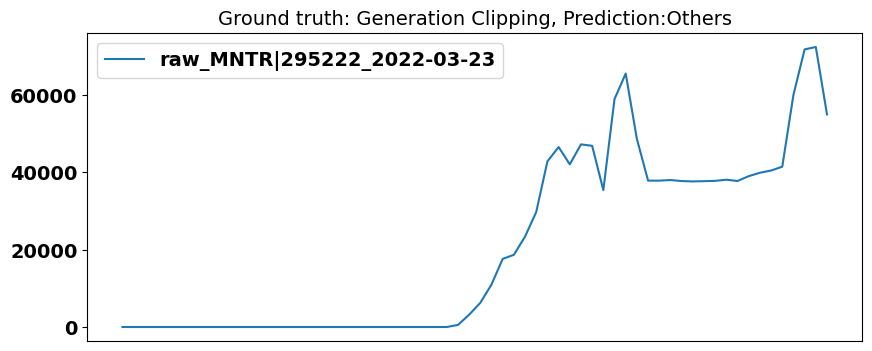

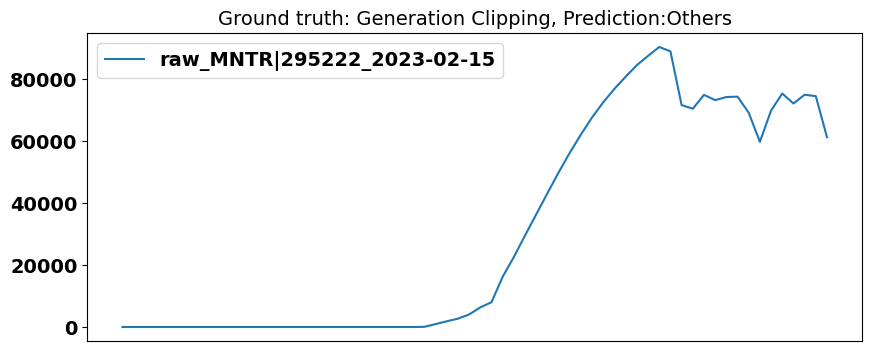

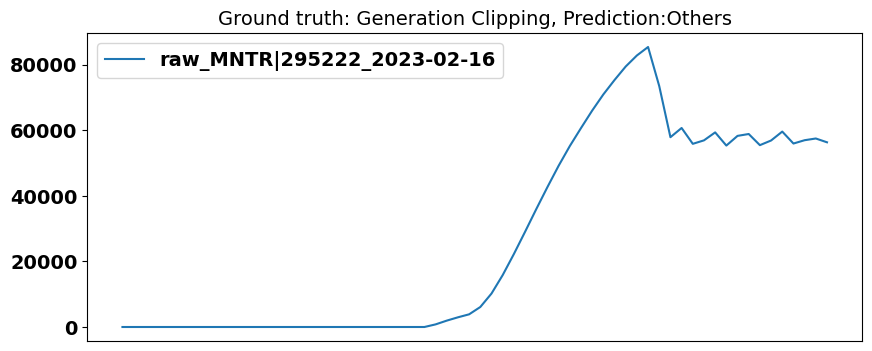

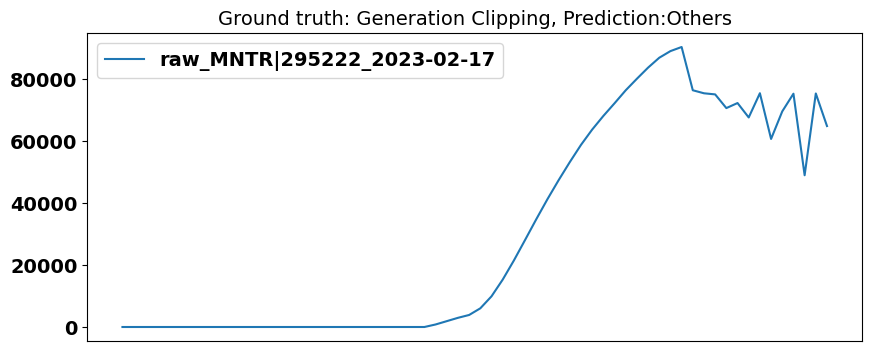

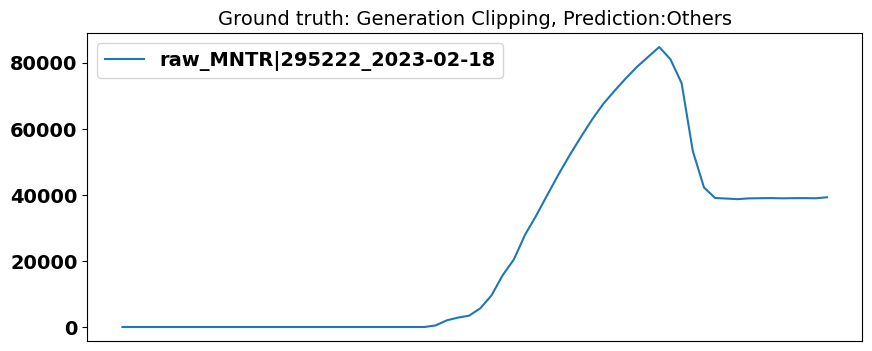

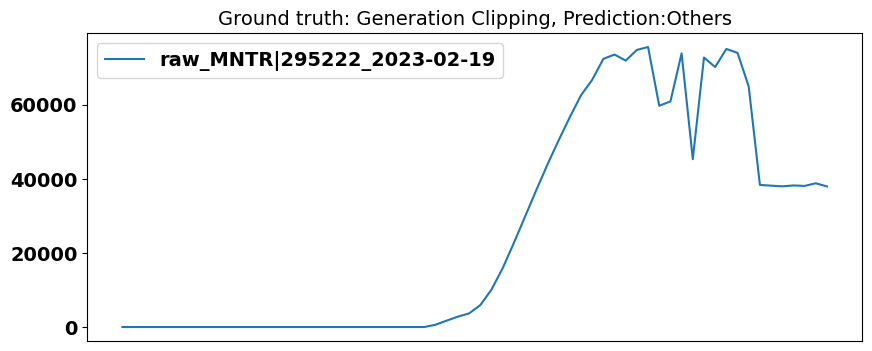

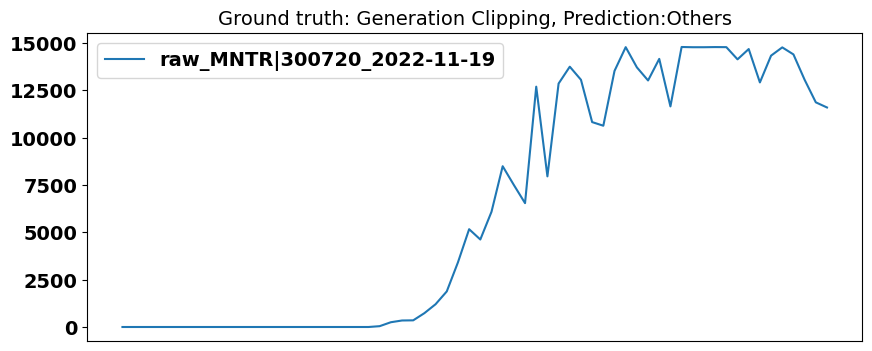

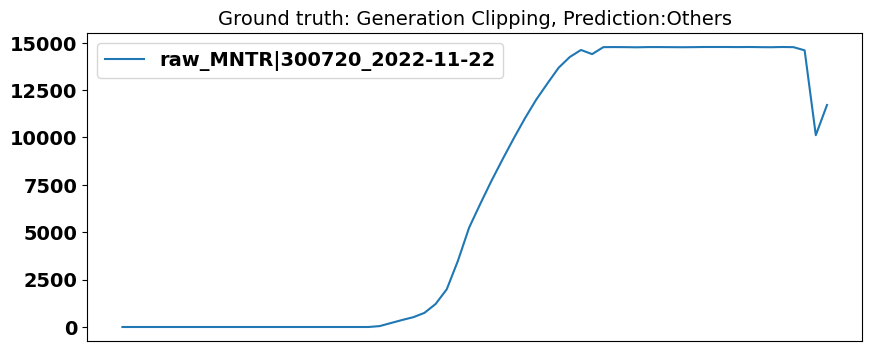

In [27]:

for i, idx in enumerate(misclassified_samples.index):
    fig, axes = plt.subplots(nrows=1, figsize=(10, 4))
    axes.plot(misclassified_samples.iloc[i, 1:65], label='raw_{}_{}'.format(misclassified_samples.iloc[i, :]['MID'], misclassified_samples.iloc[i, :]['date']))
    # axes[i].plot(df_ml_stl.iloc[idx, 1:65], label='stl')
    axes.set_title('Ground truth: {}, Prediction:{}'.format(labelnum_mapping[misclassified_samples.iloc[i,:]['Label']], labelnum_mapping[misclassified_samples.iloc[i, :]['estimated_label']]))
    axes.set_xticks([])
    axes.legend()